# Imports

In [ ]:
pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import plotly.express as px
import os

Mounted at /content/drive


In [ ]:
!gsutil cp gs://ml-lambi-public/11_CLASS_100_IMG_HD/11_class_1000_img.zip .

Copying gs://ml-lambi-public/11_CLASS_100_IMG_HD/11_class_1000_img.zip...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][  3.8 GiB/  3.8 GiB]  138.9 MiB/s                                   
Operation completed over 1 objects/3.8 GiB.                                      


In [ ]:
# Unzip file
with zipfile.ZipFile('11_class_1000_img.zip', 'r') as zip_ref:
    zip_ref.extractall("/content/datasets")
zip_ref.close()

In [ ]:
PATH = '/content/datasets/1000_class/1000img_class'
# print(os.listdir(PATH))
len_image = len(os.listdir(PATH))
print(f"Jumlah Gambar: {len_image}")

Jumlah Gambar: 10892


# Data Preprocessing

In [ ]:
file_names = os.listdir(PATH)
file_names[:10]

['cOSJgpQM.jpg',
 '2NA22S0AX-K11@1.1.jpg',
 'gGKjbkQBkZHeB.jpg',
 'kYIPDsRdGa.jpg',
 'quVQSoQlQC.jpg',
 'fLVpqeiBh.jpg',
 '3060.jpg',
 '31e17c0d-a51c-4885-91fd-07f5f04a0353.jpg',
 'AD122S084-Q11@10.jpg',
 'GOJ22S001-Q11@19.jpg']

In [ ]:
df = pd.read_csv('/content/datasets/1000_class/1000img.csv')
df.head()

,image,label
0,ea7b6656-3f84-4eb3-9099-23e623fc1018.jpg,Tshirts
1,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa.jpg,Tshirts
2,4c8f245e-a039-46fd-a6b9-1bb51e83fc05.jpg,Tshirts
3,95609fcf-b2c2-4f35-8454-a308262e30ea.jpg,Tshirts
4,534cb9e4-658e-48a9-a9d9-365149ee52e8.jpg,Tshirts


In [ ]:
fig = px.bar(df['label'].value_counts())
fig.show()

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df['label'] = df['label'].astype(str)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Model

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=PATH,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=PATH,
    x_col='image',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8716 validated image filenames belonging to 11 classes.
Found 2180 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning:

Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.



In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 11)                1419      
                                                                 
Total params: 7170123 (27.35 MB)
Trainable params: 7086475 (27.03 MB)
Non-trainable params: 83648 (326.75 KB)
__________

In [ ]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/10
272/272 [==============================] - 339s 1s/step - loss: 1.2382 - accuracy: 0.5910 - val_loss: 0.4746 - val_accuracy: 0.8438
Epoch 2/10
272/272 [==============================] - 288s 1s/step - loss: 0.6089 - accuracy: 0.8079 - val_loss: 0.3890 - val_accuracy: 0.8695
Epoch 3/10
272/272 [==============================] - 280s 1s/step - loss: 0.4604 - accuracy: 0.8542 - val_loss: 0.3594 - val_accuracy: 0.8787
Epoch 4/10
272/272 [==============================] - 279s 1s/step - loss: 0.3746 - accuracy: 0.8815 - val_loss: 0.3668 - val_accuracy: 0.8860
Epoch 5/10
272/272 [==============================] - 279s 1s/step - loss: 0.3352 - accuracy: 0.8945 - val_loss: 0.3265 - val_accuracy: 0.8971
Epoch 6/10
272/272 [==============================] - 276s 1s/step - loss: 0.3014 - accuracy: 0.9053 - val_loss: 0.3013 - val_accuracy: 0.9040
Epoch 7/10
272/272 [==============================] - 282s 1s/step - loss: 0.2602 - accuracy: 0.9173 - val_loss: 0.3246 - val_accuracy: 0.8994

# Visualize Model Predictions

Model Loss is 0.31 and Accuracy is 90.96%


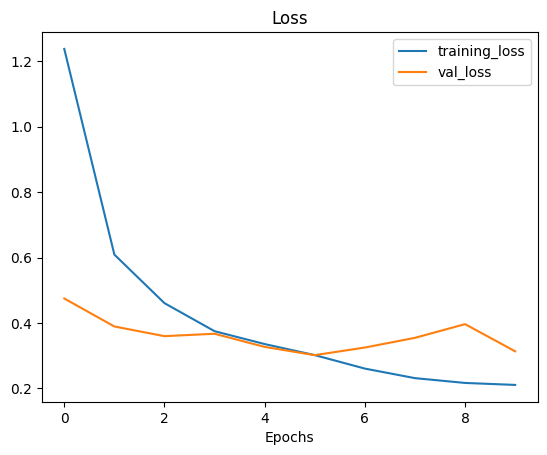

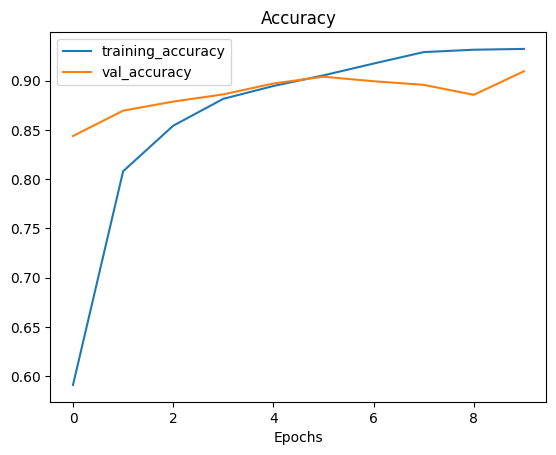

In [ ]:
loss, accuracy = model.evaluate(test_generator, verbose=0)
print(f"Model Loss is {loss:.2f} and Accuracy is {100*np.round(accuracy, 4)}%")

import matplotlib.pyplot as plt

def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history)

In [ ]:
model.save('/content/drive/MyDrive/Capstone Lambi/Lambi.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# Prediction on validation Images

In [ ]:
label_encoder.fit(train_df['label'])

# Save label encoder
np.save('/content/drive/MyDrive/Capstone Lambi/label_encoder_classes.npy', label_encoder.classes_)

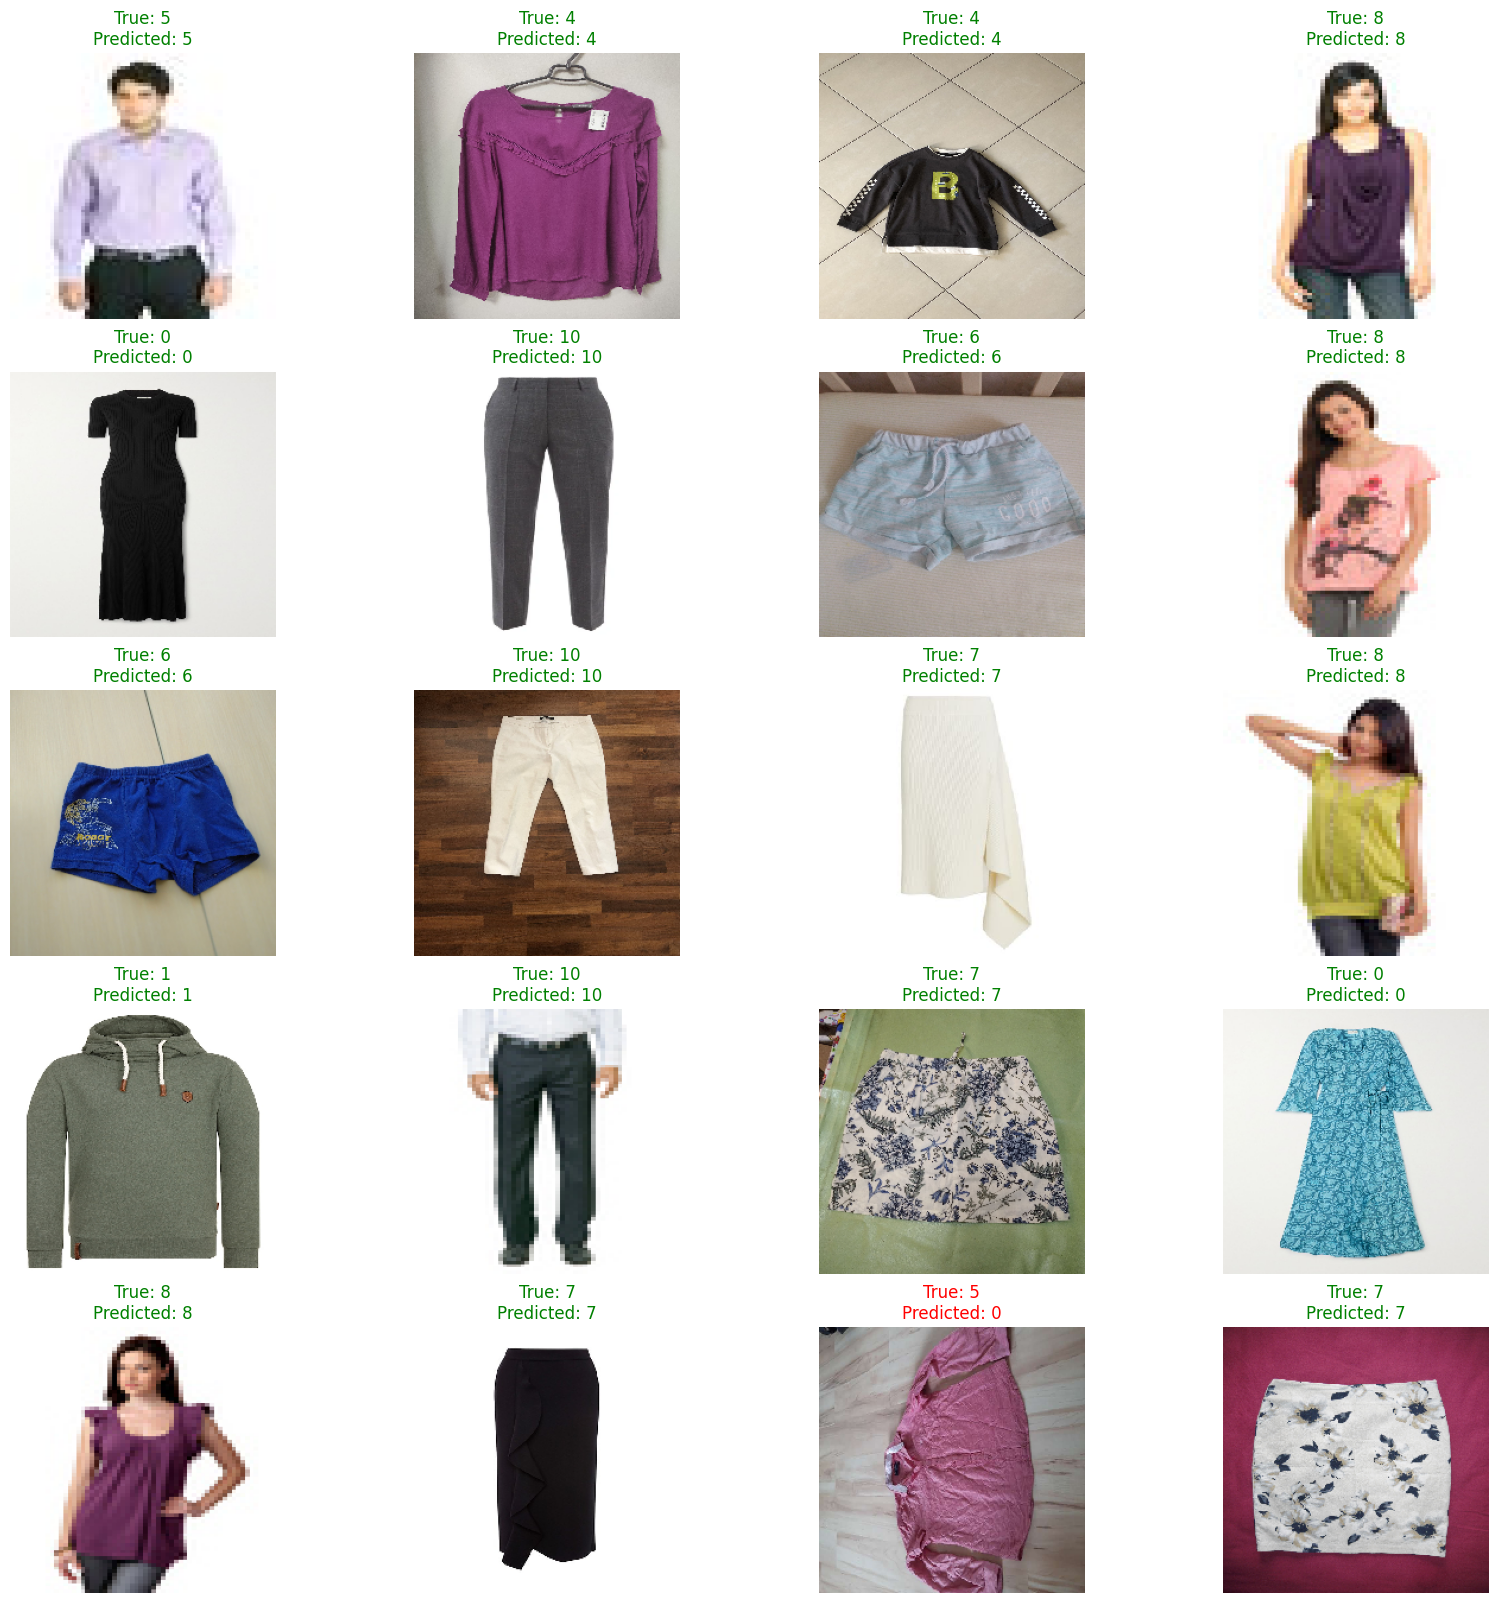

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('/content/drive/MyDrive/Capstone Lambi/label_encoder_classes.npy', allow_pickle=True)

def predict_val_image(index, val_images, val_labels, model, label_encoder):
    predictions = model.predict(val_images, verbose=0)[index]
    true_label = label_encoder.classes_[val_labels[index].argmax()]
    predicted_label = label_encoder.classes_[predictions.argmax()]

    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'

    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)
    plt.imshow(val_images[index])
    plt.axis('off')

val_images, val_labels = test_generator.next()

plt.figure(figsize=(20, 20))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    predict_val_image(i, val_images, val_labels, model, label_encoder)

plt.show()

# Class List
# 0 : Dresses
# 1 : Hoodie
# 2 : Jackets
# 3 : Jeans
# 4 : Longsleeve
# 5 : Shirts
# 6 : Shorts
# 7 : Skirts
# 8 : Tops
# 9 : Tshirts
# 10 : Pants


# Class List:
##### 0 : Dresses
##### 1 : Hoodie
##### 2 : Jackets
##### 3 : Jeans
##### 4 : Longsleeve
##### 5 : Shirts
##### 6 : Shorts
##### 7 : Skirts
##### 8 : Tops
##### 9 : Tshirts
##### 10 : Pants

# Predict Our Clothes

In [ ]:
local_dir = '/content/drive/MyDrive/Capstone Lambi/test'
classes = list(train_generator.class_indices.keys())

local_paths = []
for image in os.listdir(local_dir):
  local_paths.append(local_dir+'/'+image)

import random
def predict_random_image():
    path = random.choice(local_paths)
    image = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    input_arr = input_arr.astype('float32') / 255.
    predictions = model.predict(input_arr, verbose=0)
    series = pd.Series(predictions[0], index=classes)
    predicted_classes = np.argsort(predictions)
    predictions.sort()
    plt.title(f"{classes[predicted_classes[0][-1]]} - {round(predictions[0][-1] * 100,2)}% \n{classes[predicted_classes[0][-2]]} - {round(predictions[0][-2] * 100,2)}% \n{classes[predicted_classes[0][-3]]} - {round(predictions[0][-2] * 100,3)}%")
    plt.imshow(image)
    plt.axis('off')

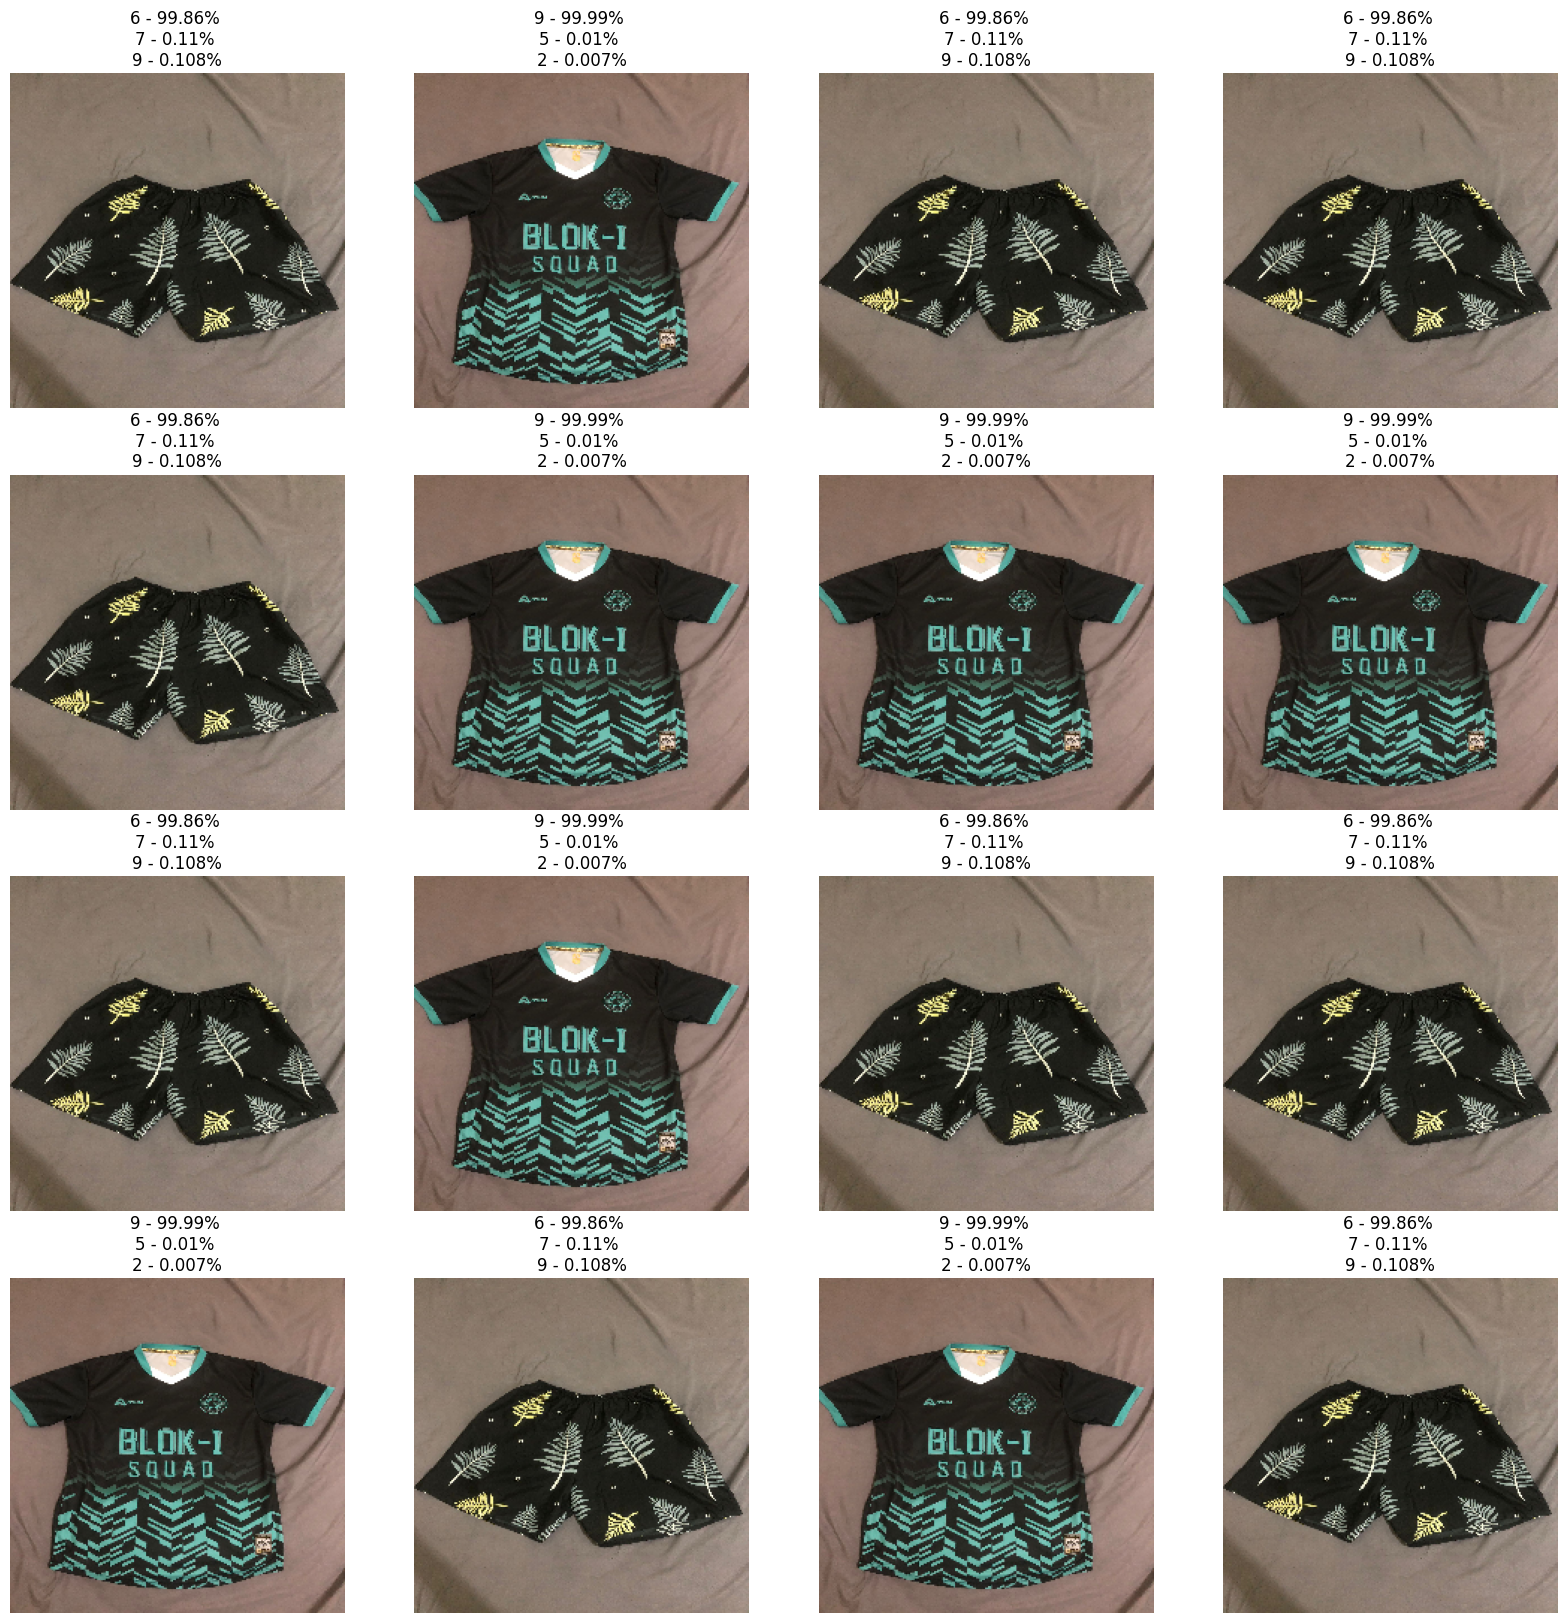

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    predict_random_image()